In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import matplotlib as plt
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from torch.nn import *
import cv2
# import wandb
# from wandb.fastai import WandbCallback

In [3]:
class CE_DiceLoss(nn.Module):
    def __init__(self):
        super(CE_DiceLoss, self).__init__()

    def forward(self, inp, target):
        inp = torch.sigmoid(inp)
        target = target.type(torch.FloatTensor).cuda()
        CE_val = nn.BCELoss(inp, target)
        dice_val = self.dice_loss(inp, target)
        
        return (CE_val + dice_val)/2
        
    def dice_loss(self, inp, target):
        smooth = 1.
        loss = 0.
        for c in range(n_classes):
            iflat = inp[:, c ].view(-1)
            tflat = target[:, c].view(-1)
            intersection = (iflat * tflat).sum()

            w = class_weights[c]
            loss += w * (1 - ((2. * intersection + smooth)/(iflat.sum() + tflat.sum() + smooth)))
        return loss

In [4]:
path = Path("/home/ubuntu/Kharbanda/Buildings")
path_img = path/'Images'
path_mask = path/'Masks'

In [5]:
all_img = get_image_files(path_img)
fname = [x for x in all_img if str(x.stem[:5]) == "3band"] 
fname[:5]

[PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img5750.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img6415.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img600.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img6329.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img435.tif')]

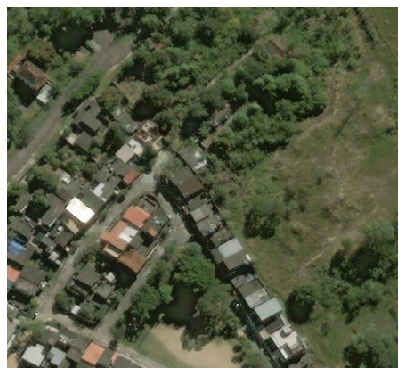

In [7]:
img = open_image(fname[14])
img.show(figsize=(7,7))

In [8]:
# string = 'Images/'
# data = [string + x.name for x in fname]

# v1_df = pd.DataFrame(data, columns = ['Images'])
# v1_df.to_csv("Rio_buildings.csv")

In [5]:
rio_df = pd.read_csv(path/'Rio_buildings.csv')
rio_df = rio_df.drop(columns = 'Unnamed: 0')
rio_df.head()

,Images
0,Images/3band_AOI_1_RIO_img5750.tif
1,Images/3band_AOI_1_RIO_img6415.tif
2,Images/3band_AOI_1_RIO_img600.tif
3,Images/3band_AOI_1_RIO_img6329.tif
4,Images/3band_AOI_1_RIO_img435.tif


In [6]:
len(rio_df)

6940

In [7]:
get_y_fn = lambda x: path_mask/f'{Path(x).name}'

In [8]:
def save_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.save(f'{City}_{Freezed}_{Size}_{Iter}')
    
def load_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.load(f'{City}_{Freezed}_{Size}_{Iter}')

In [9]:
codes = [0,'building']
random.seed(42)
src = (SegmentationItemList.from_df(rio_df, path).
      split_by_rand_pct(.1).
      label_from_func(get_y_fn, classes=codes))

In [13]:
bs = 32
size = 224
data = (src.transform(get_transforms(flip_vert = True, max_rotate = 15, max_zoom=1.5, max_lighting = 0.4), size = size, tfm_y=True).
       databunch(bs=bs).normalize(imagenet_stats))

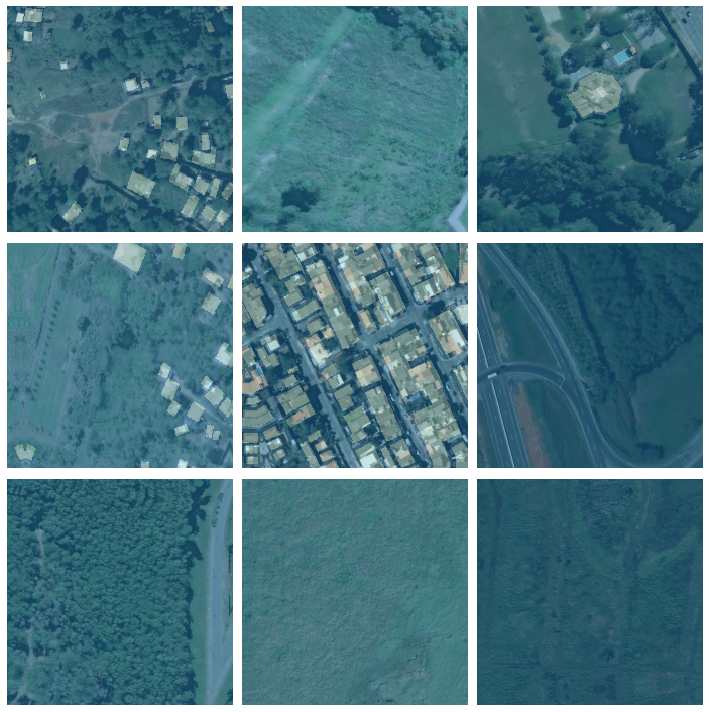

In [15]:
data.show_batch(3, figsize=(10,10))

In [16]:
# wd = 1e-3
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, 
                     norm_type=NormType.Weight, self_attention=True)
learn.loss = CE_DiceLoss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


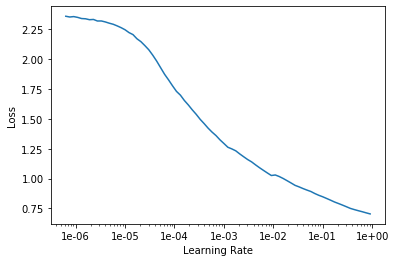

In [17]:
learn.lr_find()
learn.recorder.plot() 

In [18]:
learn.fit_one_cycle(5, slice(1e-3))

epoch,train_loss,valid_loss,dice,time
0,0.168257,0.151797,0.467539,01:20
1,0.138357,0.150642,0.423466,01:19
2,0.121167,0.118411,0.545319,01:19
3,0.118459,0.117198,0.553409,01:19
4,0.114152,0.113654,0.552930,01:20


In [19]:
save_model(learn, 'Rio', 'F', 'smol', 1)

# Start Recording

In [14]:
import wandb
from wandb.fastai import WandbCallback

In [15]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                    self_attention=True, callback_fns=partial(WandbCallback, input_type='images'))
learn.loss = CE_DiceLoss

In [12]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Rio.ipynb"

In [15]:
wandb.init(project="spacenet_buildings", name = 'Rio_smol')

W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/kgu8mm30

In [16]:
load_model(learn, 'Rio', 'F', 'smol', 1)

In [17]:
learn.fit_one_cycle(10, slice(5e-5, 5e-4), pct_start=0.6)

epoch,train_loss,valid_loss,dice,time
0,0.116916,0.103300,0.551213,01:28
1,0.113311,0.103900,0.563159,01:19
2,0.114015,0.102022,0.556232,01:19
3,0.114202,0.105673,0.564580,01:19
4,0.109383,0.104057,0.536884,01:19
5,0.111362,0.102990,0.532909,01:19
6,0.111190,0.102515,0.559623,01:19
7,0.108085,0.099334,0.561715,01:20
8,0.106789,0.098129,0.572305,01:19
9,0.102771,0.098221,0.572558,01:20


Better model found at epoch 0 with valid_loss value: 0.10329964756965637.
Better model found at epoch 2 with valid_loss value: 0.10202169418334961.
Better model found at epoch 7 with valid_loss value: 0.0993335098028183.
Better model found at epoch 8 with valid_loss value: 0.09812936186790466.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200113_101532-kgu8mm30/bestmodel.pth


In [18]:
save_model(learn, 'Rio', 'F', 'smol', 2)

In [19]:
learn.unfreeze()

In [20]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.104679,0.098177,0.570857,01:23
1,0.101905,0.098074,0.561920,01:23
2,0.106694,0.097800,0.570051,01:23
3,0.107538,0.098803,0.580170,01:23
4,0.106241,0.098820,0.575576,01:23
5,0.105064,0.097626,0.566126,01:23
6,0.104751,0.098024,0.579933,01:23
7,0.107185,0.098051,0.579832,01:23
8,0.108277,0.097819,0.581121,01:23
9,0.103478,0.097064,0.575597,01:23


Better model found at epoch 0 with valid_loss value: 0.09817664325237274.
Better model found at epoch 1 with valid_loss value: 0.09807422757148743.
Better model found at epoch 2 with valid_loss value: 0.09779980033636093.
Better model found at epoch 5 with valid_loss value: 0.09762570261955261.
Better model found at epoch 9 with valid_loss value: 0.0970638319849968.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200113_101532-kgu8mm30/bestmodel.pth


In [21]:
save_model(learn, 'Rio', 'UF', 'smol', 1)

In [22]:
learn.fit_one_cycle(10, slice(1e-6, 5e-5), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.102145,0.097066,0.574854,01:23
1,0.102943,0.096792,0.575984,01:22
2,0.102109,0.097311,0.581188,01:23
3,0.103486,0.096847,0.576097,01:23
4,0.106191,0.097081,0.579431,01:23
5,0.098132,0.097103,0.569301,01:23
6,0.101109,0.097673,0.583974,01:23
7,0.103202,0.096470,0.571551,01:23
8,0.105681,0.096734,0.578379,01:23
9,0.103036,0.096800,0.575700,01:23


Better model found at epoch 0 with valid_loss value: 0.09706644713878632.
Better model found at epoch 1 with valid_loss value: 0.09679244458675385.
Better model found at epoch 7 with valid_loss value: 0.09646964073181152.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200113_101532-kgu8mm30/bestmodel.pth


In [23]:
save_model(learn, 'Rio', 'UF', 'small', 2)

## GO BIG

In [16]:
bs = 8
size = 400
data = (src.transform(get_transforms(flip_vert = True, max_rotate = 15, max_zoom=1.5, max_lighting = 0.4), size = size, tfm_y=True).
       databunch(bs=bs).normalize(imagenet_stats))

In [17]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                    self_attention=True, callback_fns=partial(WandbCallback, input_type='images'))
learn.loss = CE_DiceLoss

In [18]:
load_model(learn, 'Rio', 'UF', 'small', 2)

In [19]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Vegas.ipynb"

In [20]:
wandb.init(project="spacenet_buildings", name = 'Rio_Big_SA')

W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/tygm32e8

In [21]:
learn.fit_one_cycle(10, slice(5e-5, 5e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.101899,0.096108,0.575873,04:52
1,0.119353,0.106366,0.575764,04:41
2,0.115929,0.096001,0.575729,04:40
3,0.107511,0.098977,0.568897,04:40
4,0.113137,0.098091,0.573605,04:40
5,0.100876,0.098569,0.573601,04:40
6,0.111329,0.100088,0.591015,04:40
7,0.114746,0.097032,0.586650,04:40
8,0.097601,0.094257,0.588401,04:40
9,0.097143,0.093145,0.590267,04:41


Better model found at epoch 0 with valid_loss value: 0.09610819816589355.
Better model found at epoch 2 with valid_loss value: 0.09600123018026352.
Better model found at epoch 8 with valid_loss value: 0.09425710141658783.
Better model found at epoch 9 with valid_loss value: 0.09314524382352829.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200113_131635-tygm32e8/bestmodel.pth


In [22]:
save_model(learn, 'Rio', 'F', 'big', 1)

In [23]:
learn.unfreeze()

In [24]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.112222,0.092930,0.591993,04:53
1,0.103837,0.092971,0.589136,04:52
2,0.101312,0.093043,0.588844,04:52
3,0.100455,0.093091,0.585803,04:52
4,0.103927,0.093938,0.593498,04:53
5,0.094299,0.093967,0.586647,04:53
6,0.096727,0.094800,0.593642,04:52
7,0.103093,0.093681,0.581855,04:52
8,0.098610,0.092258,0.592120,04:53
9,0.104223,0.092165,0.590989,04:53


Better model found at epoch 0 with valid_loss value: 0.0929303988814354.
Better model found at epoch 8 with valid_loss value: 0.09225792437791824.
Better model found at epoch 9 with valid_loss value: 0.09216489642858505.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200113_131635-tygm32e8/bestmodel.pth


In [25]:
save_model(learn, 'Rio', 'UF', 'big', 1)

In [26]:
learn.fit_one_cycle(10, slice(1e-6, 5e-5), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.098527,0.092096,0.590930,04:52
1,0.100131,0.091832,0.590335,04:52
2,0.095510,0.091889,0.588371,04:53
3,0.099880,0.092461,0.591547,04:52
4,0.100099,0.092818,0.594477,04:52
5,0.106919,0.091484,0.585635,04:53
6,0.100927,0.091630,0.588416,04:53
7,0.101794,0.091994,0.591972,04:53
8,0.092153,0.091158,0.590817,04:53
9,0.089354,0.091433,0.591780,04:52


Better model found at epoch 0 with valid_loss value: 0.09209612011909485.
Better model found at epoch 1 with valid_loss value: 0.09183219820261002.
Better model found at epoch 5 with valid_loss value: 0.09148415923118591.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200113_131635-tygm32e8/bestmodel.pth


In [27]:
save_model(learn, 'Rio', 'UF', 'big', 2)

In [28]:
learn.fit_one_cycle(10, slice(5e-7, 5e-6), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.092977,0.091379,0.591755,04:52
1,0.097619,0.091262,0.592438,04:53
2,0.102930,0.091191,0.591143,04:52
3,0.102850,0.091232,0.591758,04:52
4,0.097014,0.091355,0.592035,04:53
5,0.105627,0.090971,0.592003,04:52
6,0.100351,0.091129,0.592239,04:53
7,0.092935,0.091085,0.592268,04:52
8,0.098366,0.090991,0.593756,04:52
9,0.092315,0.091050,0.592228,04:53


Better model found at epoch 0 with valid_loss value: 0.09137945622205734.
Better model found at epoch 1 with valid_loss value: 0.09126235544681549.
Better model found at epoch 2 with valid_loss value: 0.09119148552417755.
Better model found at epoch 5 with valid_loss value: 0.09097060561180115.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200113_131635-tygm32e8/bestmodel.pth


In [29]:
save_model(learn, 'Rio', 'UF', 'big', 3)